The purpose of this notebook is to run preprocessing of gaze data in the visual search task for a single participant. It outputs a number of different visualizations, some of which are intended as sanity checks. The most informative is the 360 equirect of each trial, with the temporal evolution of gaze overlaid. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import scipy.interpolate
from matplotlib import animation, rc
from IPython.display import HTML
import imageio
import quaternion as qt
from colorspacious import cspace_converter

import visual_search_load
import visual_search_preproc

### Load single participant data.

In [13]:
## Set directories. 
direc = '/Users/angelaradulescu/Dropbox//NYU/Research/TaskVR/VisualSearchData/'
fig_direc = '/Users/angelaradulescu/Desktop/tmp'
vid_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchVideos/'
equirect_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchSpheres/'

In [14]:
## Get participants. 
data_direc, participant_list = visual_search_load.get_direc_participants('Expt2', direc)
n_participants = len(participant_list)
print('Number of participants: ' + str(n_participants))
participant_no = 20
if participant_no > n_participants: raise Exception('participant should not exceed total number of participants')
participant_id = participant_list[0]
print(participant_id)
print(participant_list)

Number of participants: 21
P2_09262018
['P2_09262018', 'P3_09272018', 'P5_09272018', 'P6_10022018', 'P7_10022018', 'P8_10032018', 'P9_10032018', 'P10_10042018', 'P11_10052018', 'P12_10052018', 'P13_10082018', 'P14_10082018', 'P15_10082018', 'P16_10082018', 'P17_10082018', 'P18_10092018', 'P20_10092018', 'P22_10102018', 'P23_10102018', 'P24_10102018', 'P26_10112018']


In [15]:
## Get camera locations. 
# These are the coordinates of the headset at the start of each trial.
# There are 30 possible locations.
camera_locations = visual_search_load.load_camera_location(data_direc)

In [16]:
## Open file with messages sent to the replay script in Unity which creates VisualSearchVideos, 
## the first-person visual experience videos.
sorted_messages = [visual_search_load.get_sorted_messages(data_direc, p) for p in participant_id.split()]

replay_messages_P2_09262018_pickled.txt


In [17]:
## Select all times at which we asked Unity to create a screenshot. These correspond to the frame times in the 
#VisualSearchVideo.mp4 movies.  
screenshot_times = [[m["event_time"] for m in s if m["event_type"]=="Screenshot"] for s in sorted_messages]

In [18]:
## Load a file containing the gaze coordinates for each screenshot -- this is just a backup.
# Need gaze_coords after interpolation. 
screen_coords = visual_search_load.load_screen_coords(vid_direc, participant_id)

In [19]:
## Open video for first participant. This does not load in all the data, just opens a stream to the video.
video = visual_search_load.open_video(participant_id, vid_direc)

/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchVideos/P2_09262018/VisualSearchVideo.mp4


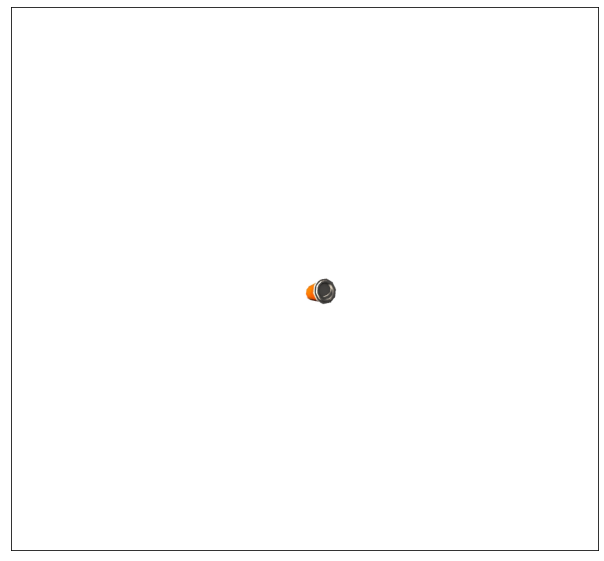

In [20]:
## Plot a random frame.
frame_no = np.random.randint(len(screenshot_times[0]))
frame = visual_search_load.get_frame(video, frame_no)

zoom = 1
fig, ax = plt.subplots(figsize=(10.8*zoom,10*zoom), linewidth=6);
ax.imshow(frame)
ax.set_xticks([])
ax.set_yticks([]);

In [21]:
## Load data (slow, so doing it for one participant). We take all keys: 'Behavior','Eye','Controller' and 'Highlights'
data = visual_search_load.load_processed_data_from_pickle(data_direc, participant_id.split(), ['Behavior','Eye','Controller','Highlights'])

/Users/angelaradulescu/Dropbox//NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Behavior.txt
/Users/angelaradulescu/Dropbox//NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Eye.txt
/Users/angelaradulescu/Dropbox//NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Controller.txt
/Users/angelaradulescu/Dropbox//NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Highlights.txt


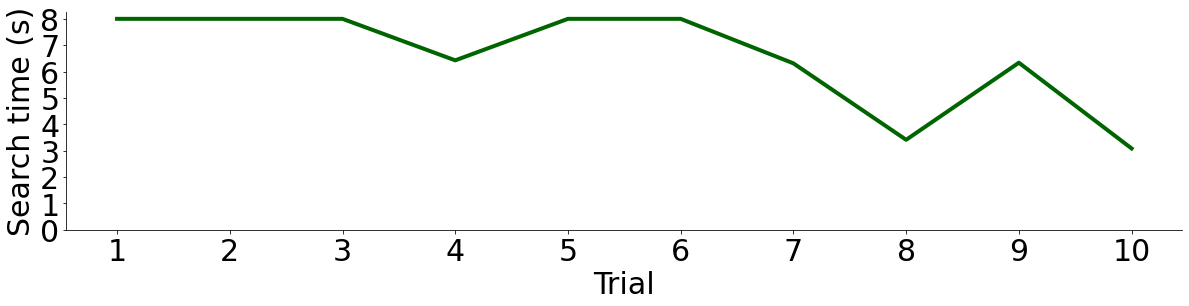

In [22]:
## Plot RTs as a sanity check (should see a ceiling at 8s).
# Compute RTs from dictionaries.
all_rts = np.vstack([np.array(d['Behavior']['SearchOverTimes'])-np.array(d['Behavior']['TrialStartTimes']) for d in data])
# Plot. 
fig, ax = plt.subplots(figsize=(20,4));
ax.plot(all_rts.T[np.arange(10)], '-', linewidth=4, color='darkgreen');
plt.xlabel('Trial', fontsize=30)
plt.ylabel('Search time (s)', fontsize=30)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(9))
ax.set_xticklabels(np.arange(10)+1, fontsize=30)
ax.set_yticklabels(np.arange(9), fontsize=30)
sns.despine()

### Gaze data preprocessing. 

##### Project to camera-centric frame. 
This step projects eyetracking samples to the trial specific camera-centric coordinate frame. These can be used to visualize gaze trajectories on 360-degree spheres specific to each trial.  

In [23]:
# Load camera locations from file. 
camera_locations = visual_search_load.load_camera_location(data_direc)

# Transform to cameracentric polar coordinates. 
gaze_from_camera_polar = [visual_search_preproc.get_gaze_direction_camera_centric(d, camera_locations) for d in data]

# Finds all indices in an array A for which the absolute difference between 
# one row of A and the next is in the 99th percentile. Used to filter extreme events in eye tracking data,
# which are likely tracking errors
nonextreme_inds = [np.logical_and.reduce([visual_search_preproc.get_nonextreme_ind(d['Eye']['HitDistance']),
                                          visual_search_preproc.get_nonextreme_ind(d['Eye']['GazeLocation']),
                                          visual_search_preproc.get_nonextreme_ind(d['Eye']['GazeDirection'])])
                   for d in data]

##### Project to egocentric frame. 
This step projects eyetracking samples from the world-centric coordinate frame used by Unity to the frame-by-frame egocentric coordinate frame.

In [24]:
# Get head and gaze direction at each screenshot time.
gaze = [visual_search_load.get_gaze_direction(d,t) for d,t in zip(data,screenshot_times)]
head = [visual_search_load.get_head_direction(d,t) for d,t in zip(data,screenshot_times)]

# Rotate gaze to egocentric coordinates for all participants
gaze_egocentric = [visual_search_preproc.rotate_gaze(h,g) for h,g in zip(head,gaze)]

# "Normalize" gaze to find intersection point with a plane located exactly 1 distance unit in front 
# of the participant, with orientation perpendicular to their gaze
# This is the plane on which Unity projects scenes to create a screenshot. 
gaze_egocentric_normalized = [g[:,:2]/np.sqrt(1-g[:,:2]**2) for g in gaze_egocentric]

# In principle, we can deduce the scaling from world to pixel coordinates using the camera's field of view 
# (76 degrees) and the number of pixels (1080 x 1000), but in practice a regression is easier and more foolproof
# We do this regression once for participant 0, and use the same scaling for all participants
# I (Bas) have ran tests ensuring the scaling is consistent between participants, and that the resulting coordinates 
# in pixel space do in fact line up with a person's eye movements.
beta = np.array([visual_search_preproc.get_gaze_to_pixel_regression(gaze_egocentric_normalized[0],screen_coords,
                                              visual_search_preproc.get_last_known_input(data[0],screenshot_times[0]),i)
                 for i in [0,1]])

# This is a list of Nx2 arrays, one for each participant, where N is the number of frames of the 
# VisualSearchVideo movie for those participants. The coordinates are not checked for overflow 
# (outside the 0-1000 and 0-1080 range)
gaze_pixel_coords = [visual_search_preproc.gaze_to_pixel_coords(g,beta) for g in gaze_egocentric_normalized]

In [28]:
len(gaze_egocentric)

1

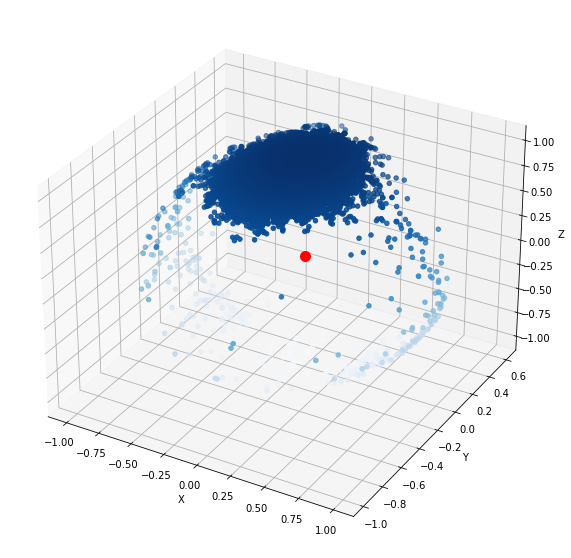

In [16]:
## Plot egocentric 3D coords.

zdata = gaze_egocentric[0][:,2]
xdata = gaze_egocentric[0][:,0]
ydata = gaze_egocentric[0][:,1]

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Blues')
ax.scatter3D(0, 0, 0, color="r", s=100)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

In [ ]:
fp = vid_direc + participant_id + '/gaze_pixel_coords.csv'
pd.DataFrame(gaze_pixel_coords[0],columns=['x','y']).to_csv(fp, index=None)

##### Pair each gaze sample with a video frame. 

In [ ]:
n_gaze_samples = len(data[0]['Eye']['TimeStamp'])
gaze_t_start = data[0]['Eye']['TimeStamp'][0]
n_screenshots = len(screenshot_times[0])
n_frames = 100
plot_up_to = screenshot_times[0][n_frames]
gaze_idx = np.where(np.asarray(data[0]['Eye']['TimeStamp'] < plot_up_to))[0]
vid_idx = np.where(screenshot_times[0] < plot_up_to)[0]

print('Number of gaze samples: ' + str(n_gaze_samples)) 
print('Number of frames: ' + str(n_screenshots)) 

## Visualize events.
t_zero = np.minimum(np.asarray(data[0]['Eye']['TimeStamp'])[gaze_idx][0], np.asarray(screenshot_times[0])[vid_idx][0])
print('T-zero: ' + str(t_zero))

fig, ax = plt.subplots(2,1, figsize=(16,4), linewidth=6, sharex=True);
ax[0].eventplot(np.asarray(data[0]['Eye']['TimeStamp'])[gaze_idx]-t_zero, 
                color=[0,0,0], linelengths=0.2, linewidths=1,);
ax[1].eventplot(np.asarray(screenshot_times[0])[vid_idx]-t_zero, 
                color=[0,0,0], linelengths=0.2, linewidths=1,);
ax[0].set_xlim(22,24)
ax[1].set_xlim(22,24)
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('Seconds', fontsize=20)
ax[0].set_ylabel('Eye', fontsize=20)
ax[1].set_ylabel('Video', fontsize=20);

In [ ]:
## Find indices for screenshot timestamps nearest each eye timestamp.
def closest_argmin(A, B):
    L = B.size
    sidx_B = B.argsort()
    sorted_B = B[sidx_B]
    sorted_idx = np.searchsorted(sorted_B, A)
    sorted_idx[sorted_idx==L] = L-1
    mask = (sorted_idx > 0) & \
    ((np.abs(A - sorted_B[sorted_idx-1]) < np.abs(A - sorted_B[sorted_idx])) )
    return sidx_B[sorted_idx-mask]
closest_video = closest_argmin(np.asarray(data[0]['Eye']['TimeStamp']), np.asarray(screenshot_times[0]))

## Grab 3D coordinates.
gaze_3d = gaze_egocentric[0][closest_video,:]

## Grab pixel position.
gaze_pixels = gaze_pixel_coords[0][closest_video,:]

## Trim the edges up to the maximum number of frames outside the edges.
counts = np.bincount(closest_video)
n_frames_start_edge = counts[0]
n_frames_end_edge = counts[-1]
print(n_frames_start_edge)
print(n_frames_end_edge)
first_three_counts = np.sort(np.bincount(closest_video))[::-1][0:3]
max_frames = np.sort(np.bincount(closest_video))[::-1][2]
gaze_pixels[0:n_frames_start_edge-max_frames, :] = np.nan
gaze_pixels[-n_frames_end_edge+max_frames:, :] = np.nan

## Grab gaze position, make dataframe and save.
gaze_position = pd.DataFrame(np.hstack((np.expand_dims(data[0]['Eye']['TimeStamp'] - gaze_t_start, axis=1),
                                       np.expand_dims(closest_video, axis=1),
                                       np.expand_dims(np.round(gaze_pixels[:,0]), axis=1), 
                                       np.expand_dims(np.round(gaze_pixels[:,1]), axis=1), 
                                       np.expand_dims(gaze_from_camera_polar[0][:,0], axis=1),
                                       np.expand_dims(gaze_from_camera_polar[0][:,1], axis=1))))

gaze_position.columns=['timestamp', 'frame', 'x_pos_pixel', 'y_pos_pixel', 'r_polar', 'theta_polar']
gaze_position['frame'] = gaze_position['frame'].values.astype(int)
gaze_position['x_pos_pixel_360'] = np.round((gaze_position['r_polar'].values+np.pi)*(4096/np.pi))
gaze_position['y_pos_pixel_360'] = np.round((-gaze_position['theta_polar'].values+np.pi/2)*(4096/np.pi))
gaze_position['mu_latitude'] = np.rad2deg(gaze_position['theta_polar'].values)+90 
gaze_position['beta_longitude'] = np.rad2deg(gaze_position['r_polar'].values)+180

gaze_position = gaze_position.fillna(-999) # this avoids a known NaN related bug in to_csv
fp = data_direc + participant_id + '_gaze_position.csv'
# gaze_position.to_csv(fp, index=None)

In [ ]:
gaze_3d.shape

### Some sanity checks and visualizations. 

##### Egocentric gaze position across all frames. 

In [ ]:
## Plot.
zoom = 1
fig, ax = plt.subplots(figsize=(10.8*zoom,10*zoom), linewidth=6);
ax.plot(gaze_pixels[:,0],gaze_pixels[:,1],'.')
plt.xlim([0,1080])
plt.ylim([0,1000])
ax.set_xticks([])
ax.set_yticks([]);

##### Histogram of gaze position over latitude and longitude of a 360 panorama.

In [ ]:
all_lat = np.rad2deg(np.unique(gaze_position['theta_polar'].values)[1:])+90
all_long = np.rad2deg(np.unique(gaze_position['r_polar'].values)[1:])+180

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,12), linewidth=6);
sns.distplot(all_lat, ax=ax[0]);
ax[0].set_xlim(0,180)
ax[0].set_xlabel('Latitude', fontsize=20)
sns.distplot(all_long, ax=ax[1]);
ax[1].set_xlim(0,360)
ax[1].set_xlabel('Longitude', fontsize=20)

##### Egocentric eye position over the frame we loaded above. 

In [ ]:
zoom = 1
fig, ax = plt.subplots(figsize=(10.8*zoom,10*zoom), linewidth=6);
ax.imshow(frame)
ax.plot(gaze_pixel_coords[0][frame_no,0],1000-gaze_pixel_coords[0][frame_no,1],'+',color='red', markersize=12)
ax.axis('off');

print("ambient luminance:",visual_search_preproc.get_ambient_luminance(frame))
print("focal luminance:",visual_search_preproc.get_focal_luminance(frame,gaze_pixel_coords[0][frame_no,:],10))
print("gaze coordinates:",gaze_pixel_coords[0][frame_no,:])
color_at_gaze = visual_search_preproc.get_color_at_gaze(frame,gaze_pixel_coords[0][frame_no,:],10)
print("color at gaze:",color_at_gaze/255)
# visual_search_preproc.show_color(color_at_gaze)

##### Plot target object frame.

Used to visualize what the target looked like to the participant. 

In [ ]:
# Grab indices for which we were in a trial. 
times_in_trials = [visual_search_preproc.get_times_in_trials(d,screen_times) for d,screen_times in zip(data,screenshot_times)]
ind = sum([[i for i,tt in t] for t in times_in_trials[0]],[])

# Segment frames into trials. 
frames_in_trial = visual_search_preproc.epoch_frames(ind)

for t in np.arange(300):
    trial = t+1
    scene = data[0]["Behavior"]["TrialOrder"][trial-1][1]
    target = visual_search_load.get_target_object(data_direc, scene)
    
    if target == 'Cylinder 1': break

target_frame_no = frames_in_trial[trial-1][0]-10
target_frame = visual_search_load.get_frame(video, target_frame_no) 

zoom = 1
fig, ax = plt.subplots(figsize=(10.8*zoom,10*zoom), linewidth=6);
ax.imshow(target_frame)
# ax.plot(gaze_pixel_coords[0][target_frame_no,0],1000-gaze_pixel_coords[0][target_frame_no,1],'+',color='red', markersize=12)
ax.axis('off');

target

##### Scatter plot of all gaze coordinates for this participant in pixel space.

In [ ]:
# Plot.
zoom = 1
fig, ax = plt.subplots(figsize=(10.8*zoom,10*zoom), linewidth=6);
ax.plot(gaze_pixel_coords[0][ind,0],gaze_pixel_coords[0][ind,1],'.-')
plt.xlim([0,1080])
plt.ylim([0,1000])
ax.set_xticks([])
ax.set_yticks([]);

##### Scatter plot of single trial gaze coordinates for this participant in pixel space.

In [ ]:
# Grab and plot gaze trajectories for one trial. 
trial = 1
frames_this_trial = np.array(frames_in_trial[trial-1])
zoom = 1
fig, ax = plt.subplots(figsize=(10.8*zoom,10*zoom), linewidth=6);
ax.plot(gaze_pixel_coords[0][frames_this_trial,0],gaze_pixel_coords[0][frames_this_trial,1],'.-')
plt.xlim([0,1080])
plt.ylim([0,1000])
ax.set_xticks([])
ax.set_yticks([]);
# Add a few frames to capture target rotation.
n_prev_frames = 100
frames_this_trial = np.concatenate((frames_this_trial[0:n_prev_frames]-n_prev_frames,frames_this_trial))

##### Full animation of gaze overlaid on frames for one trial. 

In [ ]:
# Grab number of frames. 
n_frames = len(frames_this_trial)

# Prepare figure.    
my_dpi = 96
fig, ax = plt.subplots(figsize=(1080/my_dpi,1000/my_dpi), linewidth=6);
ax.set_xticks([])
ax.set_yticks([])
blank_frame = np.zeros((1000, 1080, 3))
vid_canvas = ax.imshow(blank_frame)
gaze_canvas, = ax.plot([], [], 'r+', lw=10, markersize=12)

# Define initialization function.
def init():
    vid_canvas.set_data(blank_frame);
    gaze_canvas.set_data([], [])
    return vid_canvas, gaze_canvas,

# Define animation function.
def animate(i):
    
    # Get frame numnber.
    frame_idx = frames_this_trial[i].astype(int)
    frame = visual_search_load.get_frame(video, frame_idx)
    
    # Update frame. 
    vid_canvas.set_data(frame)
    
    # Update gaze.
    gaze_canvas.set_data(gaze_pixel_coords[0][frame_idx,0],1000-gaze_pixel_coords[0][frame_idx,1])
    
    return vid_canvas, gaze_canvas

# Call the animator. 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=n_frames, interval=0.03, blit=True)

# Save animation
# HTML(anim.to_html5_video())
anim.save(participant_id + '_' + 'trial' + str(trial) + '_animation.mp4', fps=30, dpi=my_dpi, bitrate=1500)

##### Gaze overlaid on equirectangular projections from this trial. 

In [ ]:
# Get location this trial.
trial_name = data[0]["Behavior"]["TrialOrder"][trial-1][1]
print('Trial in experiment: ' + str(trial))
print(trial_name)

# Load equirect for this trial.
im = imageio.imread(equirect_direc + trial_name + '.png')

# Get trial onset and offset. 
onset = data[0]["Behavior"]["TrialStartTimes"][trial-1]
offset = data[0]["Behavior"]["SearchOverTimes"][trial-1]

# Get gaze on this trial. 
gaze_time = np.array(data[0]["Eye"]["TimeStamp"])
gaze_this_trial_idx = np.logical_and(gaze_time > onset, gaze_time < offset)
gaze_this_trial = gaze_from_camera_polar[0][gaze_this_trial_idx]

# Grab enough colors to plot this trial's gaze. 
n_samples, dummy = gaze_this_trial.shape
print('Number of samples: ', n_samples)
cm_subsection = np.linspace(0.0, 1.0, n_samples)
colors = [cm.plasma(x) for x in cm_subsection]

# Make plot without gaze. 
fig = plt.figure()
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(im, extent=[-np.pi, np.pi, -np.pi/2, np.pi/2], aspect='auto')
ax.set_axis_off()

In [ ]:
# Make plot with gaze. 
fig = plt.figure()
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(im, extent=[-np.pi, np.pi, -np.pi/2, np.pi/2], aspect='auto')
for i, color in enumerate(colors):

    # Plot point. 
    ax.plot(gaze_this_trial[i,0],gaze_this_trial[i,1],'.',markersize=12,color=color);
    
    # Plot connecting line. 
    if i < n_samples:
        ax.plot(gaze_this_trial[i:i+2,0],gaze_this_trial[i:i+2,1],'-',linewidth= 1 ,color=color);
ax.set_axis_off()

In [ ]:
# Make plot with gaze in pixels to check the conversion. 
fig = plt.figure()
fig.set_size_inches(16,8)
ax = plt.Axes(fig, [0., 0., 1., 1.])
fig.add_axes(ax)
ax.imshow(im)
for i, color in enumerate(colors):

    # Plot point. 
    ax.plot((gaze_this_trial[i,0]+np.pi)*(4096/np.pi),(-gaze_this_trial[i,1]+np.pi/2)*(4096/np.pi),'.',markersize=12,color=color);
    
ax.set_axis_off()

##### Histogram of number of frames per trial. 

In [ ]:
# Gather values in array.
n_frames_per_trial = np.ones(300)*np.nan
for i in np.arange(len(frames_in_trial)): n_frames_per_trial[i] = len(frames_in_trial[i])

# Get total number of frames.     
total_n_frames = np.sum(n_frames_per_trial)
    
fig, ax = plt.subplots(figsize=(20,8));
plt.hist(n_frames_per_trial, bins=np.arange(250), color='gray');
plt.xlabel('# frames per trial', fontsize=30)
plt.ylabel('Count', fontsize=30)
ax.set_title(participant_id + '\n Total # frames: ' + str(total_n_frames.astype(int)) + '\n Resolution: 1080 x 1000', fontsize=30)
ax.set_xticks(np.arange(0,260,10))
ax.set_xticklabels(np.arange(0,260,10), fontsize=20)
ax.set_yticks(np.arange(0,30,5))
ax.set_yticklabels(np.arange(0,30,5), fontsize=20)
sns.despine()